<a href="https://colab.research.google.com/github/chrisfinan/GenAI/blob/main/HW6/Problem1_EC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chris Finan

> 12/6/24

> HW 6 Extra Credit

# 🎶 Description

* In this project, I will develop a music generation model using Transformers, specifically designed to generate new musical compositions in the style of Chopin.

* I downloaded midi files of Chopin's music and placed them in a zip file to prepare them to be used in this project.

* The main objective here is to explore the application of Transformer models to music generation and understand the steps necessary for preparing, training, and evaluating such a model.

* Note: in both the files, I commented out the generation after each epoch, so the training completes much quicker. I also put the transformer_utils.py file in the notebooks rather than importing it.

## 0. Transformer Utils, Import Statements, Mount Drive, and Parameters

In [1]:
#@title transformer_utils.py

import os
import pickle as pkl
import music21
import keras
import tensorflow as tf

from fractions import Fraction


def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes.append("START")
        durations.append("0.0")

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)
        print(f"{len(notes)} notes parsed")

    notes_list = []
    duration_list = []

    print(f"Building sequences of length {seq_len}")
    for i in range(len(notes) - seq_len):
        notes_list.append(" ".join(notes[i : (i + seq_len)]))
        duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pkl.dump(duration_list, f)

    return notes_list, duration_list


def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pkl.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pkl.load(f)
    return notes, durations


def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [2]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [3]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21
'''
from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)'''

'\nfrom transformer_utils import (\n    parse_midi_files,\n    load_parsed_files,\n    get_midi_note,\n    SinePositionEncoding,\n)'

In [4]:
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

# Paths
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/GenAI/Chopin.zip'
extract_to = '/content/'

# Extract the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')

Mounted at /content/drive


['.config',
 'Chopin-_Prelude_in_C_Minor_mm.5-6_chromatic_run.mid',
 'Nocturne_in_D-flat_Major,_Op._27,_No._2.mid',
 'Chopin-ballade-4.mid',
 'Chopin-op62-no2-new.mid',
 'Chopin_-_Sonata,_Op._35,_I_augmented_seventh_chord.mid',
 'Chopin-Beispiel-2.mid',
 'Chopin_op_10_1_Czerny_score.mid',
 'ChopinOp28no6_score_bass.mid',
 'drive',
 'ChopinOp28no6.mid',
 'Chopin_Prelude_7.mid',
 'Chopin_minor_second.mid',
 'Chopin_nocturne_op27_2b.mid',
 'Chopin_-_Prelude_in_C_minor_opening_modulation.mid',
 'Fantaisie-Impromptu.mid',
 'Chopin_Prelude_Op_28_No_19_consecutive_diminished_seventh_chords_as_whole_tone_scale_harmony.mid',
 'Chopin_-_Mazurka_in_F_minor,_op._68,_no._4,_m._1-4,_dominant_sevenths.mid',
 'Chopin_Minute_Waltz_opening.mid',
 'Chopin_-_op._28,_no._21,_mm.1-4.mid',
 'Impromptu_No._1_in_A_flat_major,_Op._29_(coda).mid',
 'Chopin_Nocturne_no_19_in_E_minor.mid',
 'Impromptu_No._1_in_A_flat_major,_Op._29_(first_foru_bars).mid',
 'Successive_secondary_dominants_in_Chopin_op_26_no_1.mid',


In [5]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [6]:
# Load the data
file_list = glob.glob("/content/*.mid")
print(f"Found {len(file_list)} midi files")

Found 23 midi files


In [7]:
parser = music21.converter

In [8]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [9]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x793798c8a500>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=75>
    {0.0} <music21.key.Key of D- major>
    {0.0} <music21.meter.TimeSignature 6/8>
    {0.0} <music21.chord.Chord C#2>
    {0.25} <music21.chord.Chord F4>
    {0.5} <music21.chord.Chord G#3>
    {0.75} <music21.chord.Chord F4>
    {1.0} <music21.chord.Chord C#4>
    {1.25} <music21.chord.Chord F3>
    {1.5} <music21.chord.Chord C#3>
    {1.75} <music21.chord.Chord F4>
    {2.0} <music21.chord.Chord G#3>
    {2.25} <music21.chord.Chord F4>
    {2.5} <music21.chord.Chord C#4>
    {2.75} <music21.chord.Chord F3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord C#2 F5>
    {0.25} <music21.chord.Chord F4 F5>
    {0.5} <music21.chord.Chord G#3 F5>
    {0.75} <music21.chord.Chord F4 F5>
    {1.0} <music21.chord.Chord C#4 F5>
   

In [10]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/Chopin-_Prelude_in_C_Minor_mm.5-6_chromatic_run.mid
13 notes parsed
2 Parsing /content/Nocturne_in_D-flat_Major,_Op._27,_No._2.mid
52 notes parsed
3 Parsing /content/Chopin-ballade-4.mid


<ipython-input-10-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


2535 notes parsed
4 Parsing /content/Chopin-op62-no2-new.mid
2568 notes parsed
5 Parsing /content/Chopin_-_Sonata,_Op._35,_I_augmented_seventh_chord.mid
2577 notes parsed
6 Parsing /content/Chopin-Beispiel-2.mid
2645 notes parsed
7 Parsing /content/Chopin_op_10_1_Czerny_score.mid
2792 notes parsed
8 Parsing /content/ChopinOp28no6_score_bass.mid
2808 notes parsed
9 Parsing /content/ChopinOp28no6.mid
2815 notes parsed
10 Parsing /content/Chopin_Prelude_7.mid
2871 notes parsed
11 Parsing /content/Chopin_minor_second.mid
2896 notes parsed
12 Parsing /content/Chopin_nocturne_op27_2b.mid
2930 notes parsed
13 Parsing /content/Chopin_-_Prelude_in_C_minor_opening_modulation.mid
2948 notes parsed
14 Parsing /content/Fantaisie-Impromptu.mid
5461 notes parsed
15 Parsing /content/Chopin_Prelude_Op_28_No_19_consecutive_diminished_seventh_chords_as_whole_tone_scale_harmony.mid
5495 notes parsed
16 Parsing /content/Chopin_-_Mazurka_in_F_minor,_op._68,_no._4,_m._1-4,_dominant_sevenths.mid
5520 notes pa

In [11]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 E4 E4 rest E4 G#4 F#4 G#4 F#4 F#4 F4 A4 G#4 C#5 G#4 G#4 G4 B4 B-4 E-5 B-4 B-4 A4 C#5 C5 F#5 F5 B-5 A5 C#6 C6 F6 E-6 F#6 F6 G6 F6 F#6 F6 G6 F6 F#6 F6 G6 F6 F#6 F6 G6 F6 E6 F6 F7 ...

Duration string
 1/6 1/6 1/12 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [12]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [13]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        26         4
        26         4
        31         5
        26         2
         4         2
        25         2
         4         2
        25         2
        25         2
        21         2
        11         2


In [14]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 97
0: 
1: [UNK]
2: E-5
3: C#5
4: G#4
5: F5
6: F#5
7: E5
8: B-4
9: G#5

DURATIONS_VOCAB: length = 22
0: 
1: [UNK]
2: 0.25
3: 1/3
4: 1/6
5: 1/12
6: 0.5
7: 1.0
8: 0.0
9: 0.75


## 3. Create the Training Set <a name="create"></a>

In [15]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [16]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[37,  9,  9, ...,  9,  9,  9],
       [ 9,  9,  9, ...,  9,  9, 14],
       [ 9,  9,  3, ...,  9, 14,  2],
       ...,
       [18, 18, 10, ..., 21, 21, 36],
       [18, 10, 30, ..., 21, 36, 19],
       [10, 30, 34, ..., 36, 19, 19]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[6, 7, 6, ..., 6, 7, 3],
       [7, 6, 7, ..., 7, 3, 4],
       [6, 7, 6, ..., 3, 4, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9,  9,  9, ...,  9,  9, 14],
       [ 9,  9,  3, ...,  9, 14,  2],
       [ 9,  3,  3, ..., 14,  2,  2],
       ...,
       [18, 10, 30, ..., 21, 36, 19],
       [10, 30, 34, ..., 36, 19, 19],
       [30, 34, 34, ..., 19, 19, 19]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 7,  6,  7, ...,  7,  3,  4],
       [ 6,  7,  6, ...,  3,  4,  2],
       [ 7,  6,  6, ...,  4,  2

## 4. Create the causal attention mask function <a name="causal"></a>

In [17]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 5. Create a Transformer Block layer <a name="transformer"></a>

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 6. Create the Token and Position Embedding <a name="embedder"></a>

In [19]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

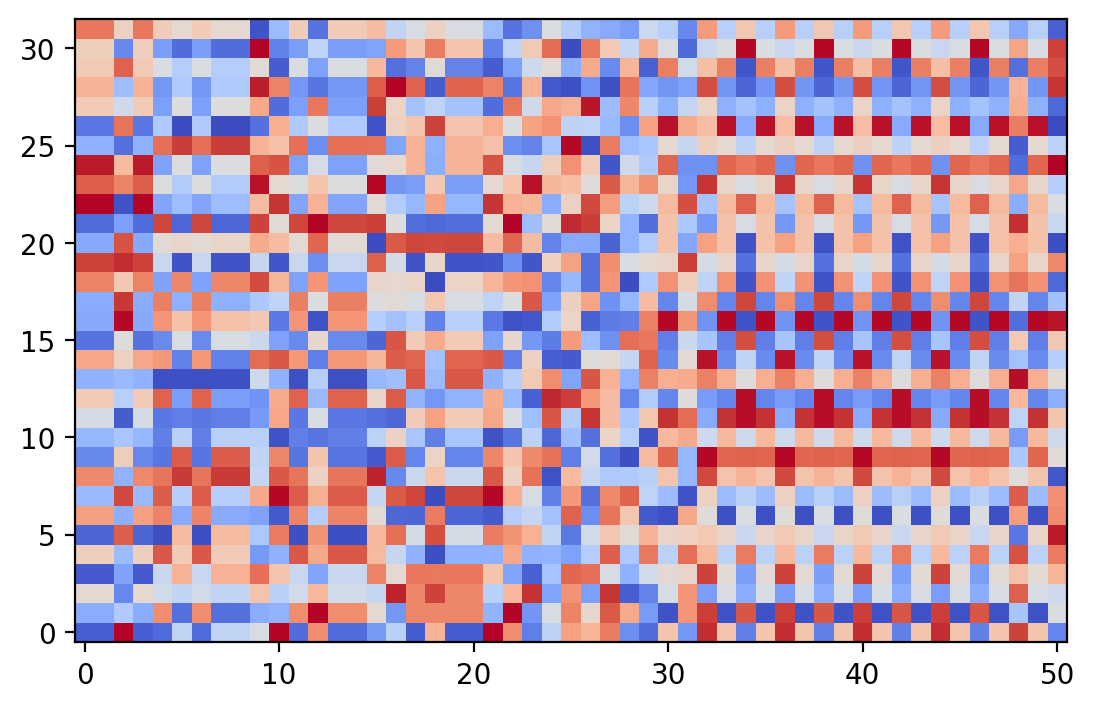

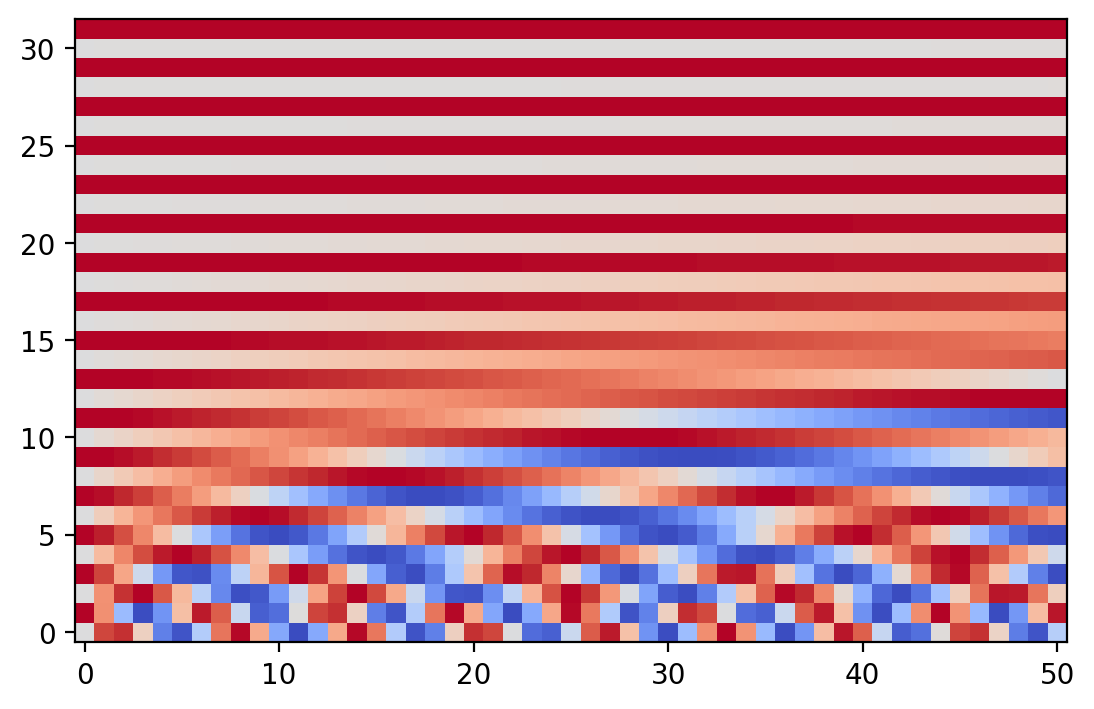

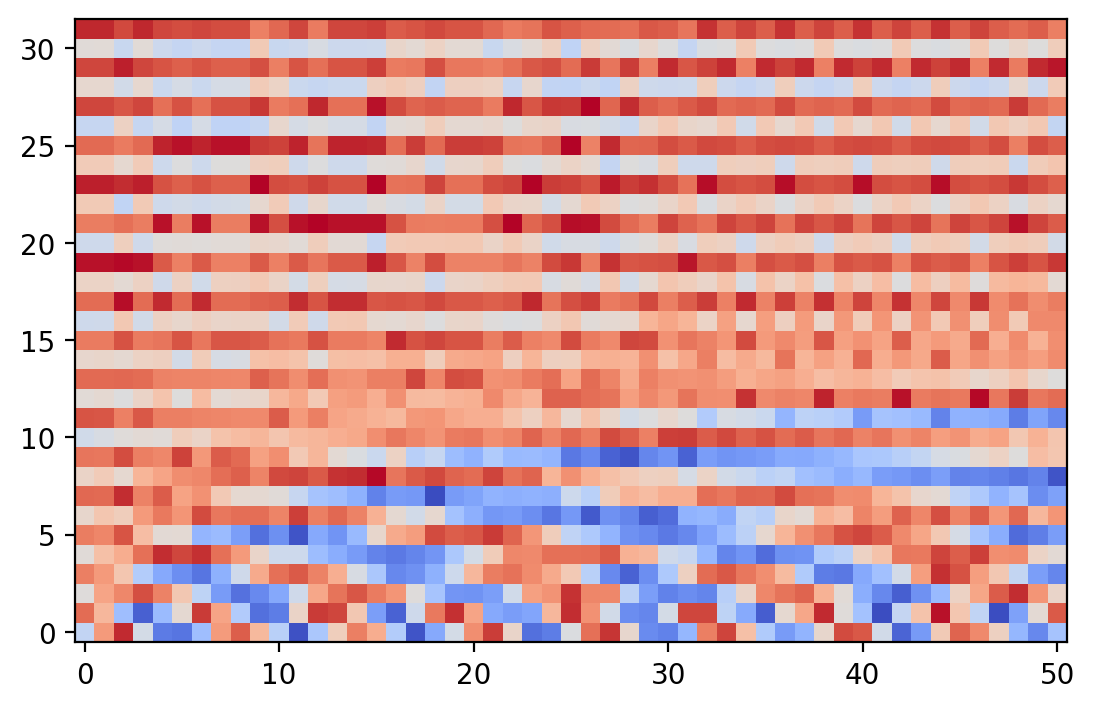

In [20]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 7. Build the Transformer model <a name="transformer_decoder"></a>

In [21]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │         12,416 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          2,816 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 97)       │         24,929 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 22)       │          5,654 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,493,239 (5.70 MB)

 Trainable params: 1,493,239 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the Transformer <a name="train"></a>

In [23]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info
'''
    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )'''

'\n    def on_epoch_end(self, epoch, logs=None):\n        info = self.generate(\n            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5\n        )\n        midi_stream = info[-1]["midi"].chordify()\n        print(info[-1]["prompt"])\n        #midi_stream.show()\n        midi_stream.write(\n            "midi",\n            fp=os.path.join(\n                "/content/output",\n                "output-" + str(epoch).zfill(4) + ".mid",\n            ),\n        )'

In [24]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [25]:
model.fit(
    ds,
    epochs=500,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - duration_outputs_loss: 3.2902 - loss: 7.5495 - note_outputs_loss: 4.2594
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - duration_outputs_loss: 1.1962 - loss: 4.9849 - note_outputs_loss: 3.7887
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - duration_outputs_loss: 0.9370 - loss: 4.3639 - note_outputs_loss: 3.4269
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - duration_outputs_loss: 0.8615 - loss: 3.8254 - note_outputs_loss: 2.9639
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - duration_outputs_loss: 0.8933 - loss: 3.7656 - note_outputs_loss: 2.8723
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - duration_outputs_loss: 0.8039 - loss: 3.3493 - note_outputs_loss: 2.5455
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - duration_outputs_loss: 0.7843 - loss: 3.2852 - note_outputs_loss: 2.5009
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - duration_outputs_loss: 0.7874 - loss: 3.1766 - note_outp

In [26]:
# Save the final model
model.save("/content/model.keras")

## 9. Generate music using the Transformer

In [27]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## 10. Write music to MIDI file and output it in My Drive

In [28]:
timestr = time.strftime("%Y%m%d-%H%M%S")
output_dir = "/content/drive/MyDrive/Colab Notebooks/GenAI/transformer_output"  # The directory to save the file

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

midi_stream.write(
    "midi",
    fp=os.path.join(
        output_dir,
        "output-" + timestr + ".mid",
    ),
)

'/content/drive/MyDrive/Colab Notebooks/GenAI/transformer_output/output-20241206-233029.mid'

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 11. Note probabilities

In [30]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

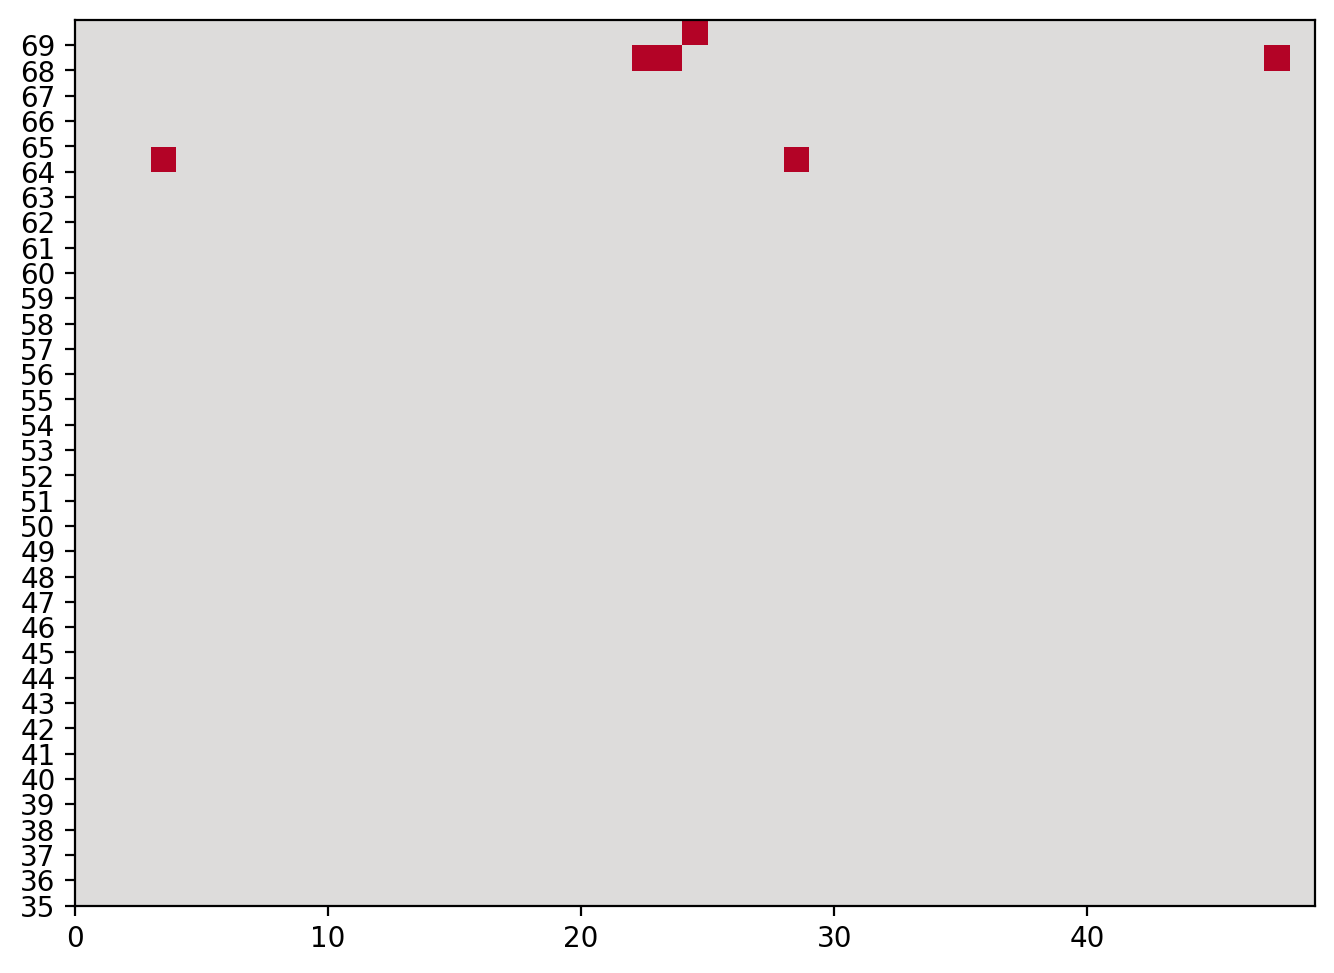

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## 12. Attention Plot

In [32]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [33]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

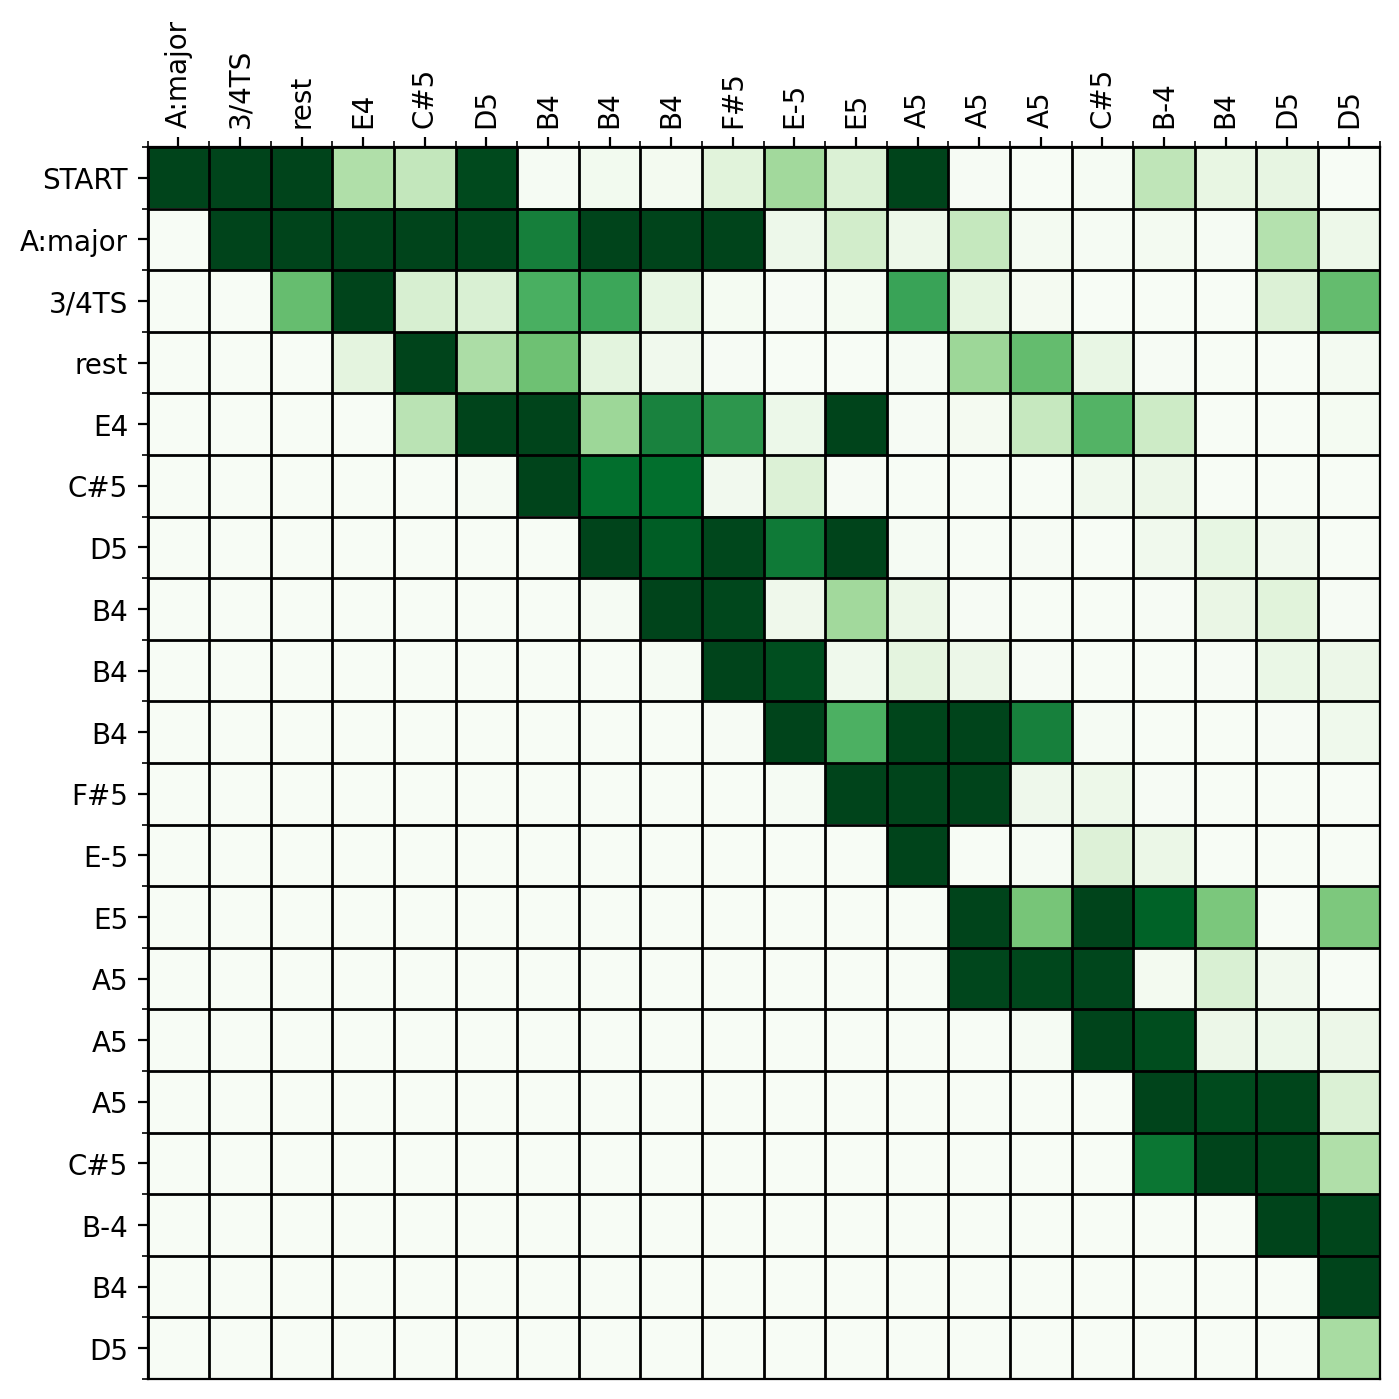

In [34]:
# As you can see, this plot looks very similar to the causal masking.
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

## 13. Conclusion

I decided to choose Chopin for an additional composer because I wanted to see how this model could generate when trained on works of art by a very expressive musician. Overall, I think the quality of the music was slightly worse compared to the Bach dataset, but that could also be because these pieces are all random and some are very short in length. The attempt with 100 epochs was very repetitive and also switched clefs a few times, so I attempted with more epochs and a higher temperature. The 500 epoch version with 0.9 temperature sounded better but was still not as good as some of the cello pieces. The 100 epochs version contained a majority of quarter notes with only one eighth note and the 500 epochs version was all eighth notes except for 2 quarter notes. Because this model was training so quickly on Chopin, I decided to make an attempt using 10000 epochs and a temperature of 1. This one sounded the best so far and for some reason when I opened it up on musescore, it had a bunch of empty lines for other instruments. It was really strange because none of the other pieces I generated did that. It took quite some time to train, so I hope you enjoy it.

References:
* https://github.com/bforoura/GenAI/blob/main/Module7/bach_transformer.ipynb
* https://commons.wikimedia.org/wiki/Category:MIDI_files_of_music_by_Fr%C3%A9d%C3%A9ric_Chopin